In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# constant definition
D_e = 3e-10; D_EC = 5e-10; t_0plus = 0.3; trans_i = -1.4;  D_cross = -1.5e-9; i_app = 4.8;   F = 9.6E4;
c_init = 1000; c_EC_init= 4000; c_tot_init = 6000; 

In [3]:
model = pybamm.BaseModel()
c  = pybamm.Variable("Li+ Concentration", domain="negative electrode")
co = pybamm.Variable("EC Concentration", domain="negative electrode")
N    = - D_e*pybamm.grad(c) - D_cross*(c_init/c_tot_init)*pybamm.grad(co) + t_0plus*i_app/F  # define the Li+ flux
N_EC = - D_cross*(c_EC_init/c_tot_init)*pybamm.grad(c) - D_EC*pybamm.grad(co) - trans_i*i_app/F  # define the EC flux
dcdt  = -pybamm.div(N)     # define the rhs equation for Li+
dcodt = -pybamm.div(N_EC)  # define the rhs equation for EC
model.rhs = {c: dcdt,co:dcodt}  # add the equation to rhs dictionary
# initial conditions
model.initial_conditions = {c: pybamm.Scalar(c_init),co: pybamm.Scalar(c_EC_init)}
# boundary conditions

# calculate for boundary conditions:
a1 = D_e;                               b1 = D_cross * (c_init/c_tot_init);   c1 = -(1-t_0plus)*i_app/F;
a2 = D_cross * (c_EC_init/c_tot_init);  b2 = D_EC;                            c2 = -trans_i*i_app/F;
y_temp = (c2 - a2/a1*c1) / (b2 - a2/a1*b1);   x_temp = (c1 - b1*y_temp) / a1


model.boundary_conditions = {c: {"left": (x_temp, "Neumann"),"right": (x_temp, "Neumann")},  co: {"left": (y_temp, "Neumann"),"right": (y_temp, "Neumann")} }
model.variables = {"Li+ Concentration": c, "Li+ Flux": N,"EC Concentration": co, "EC Flux": N_EC}
# define geometry
x = pybamm.SpatialVariable(
    "x", domain=["negative electrode"], coord_sys="cartesian"
)
geometry = {"negative electrode": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(8e-3)}}}
# mesh and discretise
submesh_types = {"negative electrode": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh)}
var_pts = {x: 40}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {"negative electrode": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

2022-09-06 13:13:56,377 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].
2022-09-06 13:13:56,383 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative electrode. Using default of 1 [m].


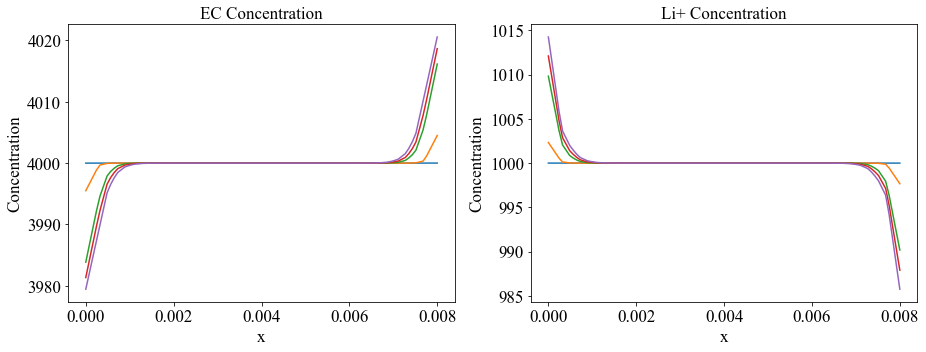

In [4]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 100, 100)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Li+ Concentration"];  co = solution["EC Concentration"];

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
x= np.linspace(0, 8e-3, 100)
ax1.plot(x, co(t=0.01, x=x))
ax1.plot(x, co(t=10, x=x))
ax1.plot(x, co(t=60, x=x))
ax1.plot(x, co(t=80, x=x))
ax1.plot(x, co(t=100, x=x))
ax1.set_xlabel("x")
ax1.set_ylabel("Concentration")
ax1.set_title("EC Concentration")


ax2.plot(x, c(t=0.01, x=x))
ax2.plot(x, c(t=10, x=x))
ax2.plot(x, c(t=60, x=x))
ax2.plot(x, c(t=80, x=x))
ax2.plot(x, c(t=100, x=x))
ax2.set_xlabel("x")
ax2.set_ylabel("Concentration")
ax2.set_title("Li+ Concentration")
plt.tight_layout()
plt.show()